# Import dependencies

In [608]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error , mean_absolute_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Upload Data and Indexing with Time

In [574]:
#load the dataset
df_daily = pd.read_csv("C:\\Users\\User\\Desktop\\Ryerson\\CIND 820\\Dataset\\salesdaily.csv")
df_daily.drop(['Year','Month','Hour','Weekday Name'], axis=1, inplace=True)
df_daily['datum'] = pd.to_datetime(df_daily['datum'])
df_daily.rename(columns = {'datum':'Date'}, inplace = True)

# Set the date as index 
df_daily = df_daily.set_index('Date')

# Select the proper time period for weekly aggreagation
df = df_daily['2014-01-02':'2019-10-8'].resample('W').sum()
df.head()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
Date,,,,,,,,
2014-01-05,14.00,11.67,21.30,185.95,41.00,0.00,32.00,7.00
2014-01-12,29.33,12.68,37.90,190.70,88.00,5.00,21.00,7.20
2014-01-19,30.67,26.34,45.90,218.40,80.00,8.00,29.00,12.00
2014-01-26,34.00,32.37,31.50,179.60,80.00,8.00,23.00,10.00
2014-02-02,31.02,23.35,20.70,159.88,84.00,12.00,29.00,12.00


# Visulization  of the data

##### To check the nature of the data

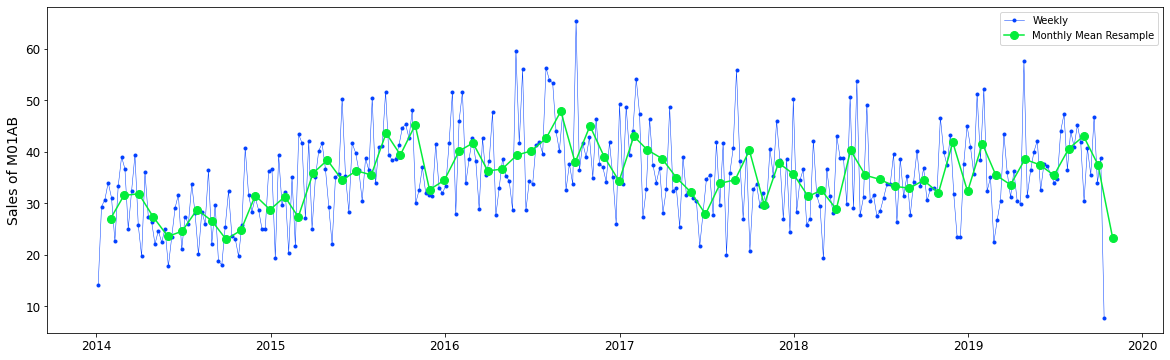

In [575]:
y = df['M01AB']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Sales of M01AB')
ax.legend();

##### mean is not constant, variance is altering, and some seasonality is also visible

# Decomposing the Data

##### To visualize trend, seasonality and residual of data

In [576]:
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

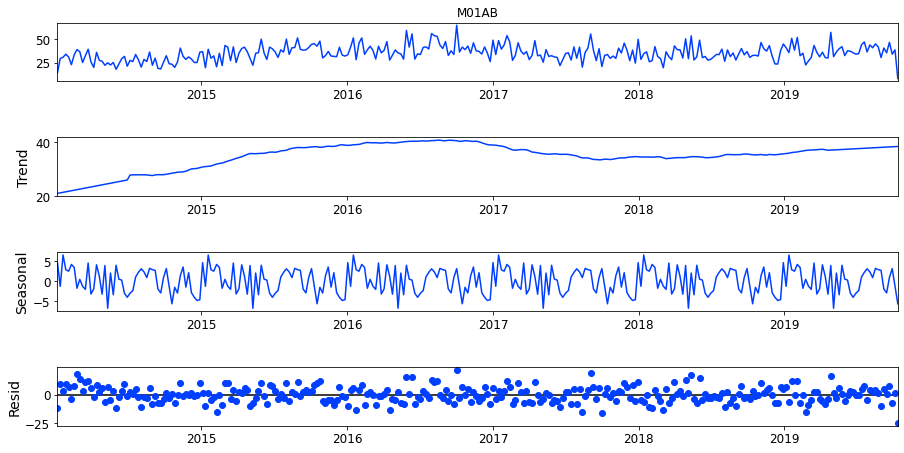

In [577]:
seasonal_decompose(y)

##### trend is increasing and yearly seasonality is present

# Partial autocorrelation & Autocorrelation 

##### To determine randomness and stationarity of the time series

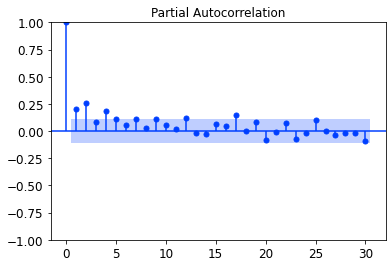

In [578]:
pacf_plot = plot_pacf(df['M01AB'] , lags=30)

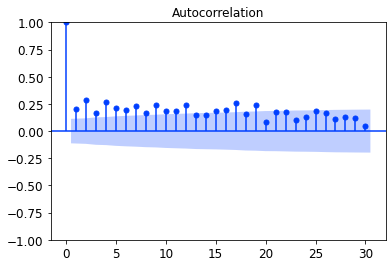

In [579]:
acf_plot = plot_acf(df['M01AB'] , lags=30)

# Checking Stationarity

### Visualization: Graphing the rolling statistics

In [580]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

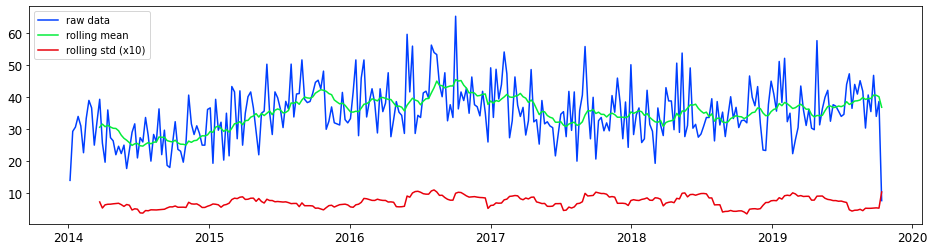

In [581]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

##### both the mean and the standard deviation are changing over time

### Augmented Dickey-Fuller Test

In [582]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller , kpss

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [583]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -3.629
P-value = 0.005
Critical values :
	1%: -3.452713099849546 - The data is  stationary with 99% confidence
	5%: -2.871387839457783 - The data is  stationary with 95% confidence
	10%: -2.5720171933352485 - The data is  stationary with 90% confidence


### KPSS

In [584]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df["M01AB"], regression="ct", nlags="auto")

KPSS Statistic: 0.4559370681608399
p-value: 0.01
num lags: 7
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Result: The series is not stationary


# Detrending

##### removes underlying trend of the time series

 > Is the de-trended data stationary ?
Test statistic = -9.734
P-value = 0.000
Critical values :
	1%: -3.453261605529366 - The data is  stationary with 99% confidence
	5%: -2.87162848654246 - The data is  stationary with 95% confidence
	10%: -2.5721455328896603 - The data is  stationary with 90% confidence


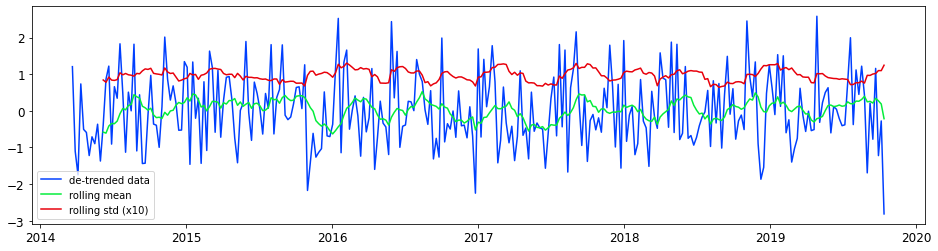

In [585]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

# Differencing

##### removes underlying seasonal or cyclical pattern of the time series

 > Is the differenced data stationary ?
Test statistic = -7.111
P-value = 0.000
Critical values :
	1%: -3.4535050041524245 - The data is  stationary with 99% confidence
	5%: -2.8717352599720294 - The data is  stationary with 95% confidence
	10%: -2.5722024776854417 - The data is  stationary with 90% confidence


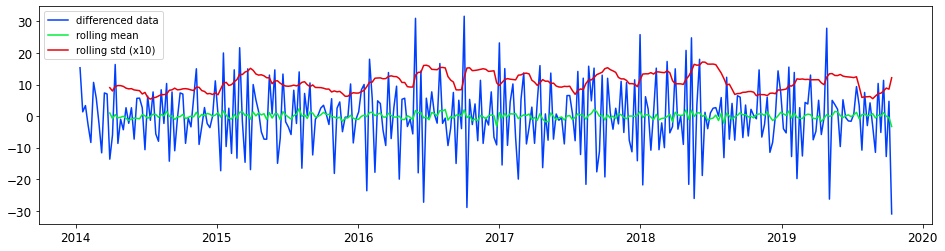

In [586]:
# Differencing
first_diff = df['M01AB'].diff()
test_stationarity(first_diff,'differenced data')
ADF_test(first_diff,'differenced data')

# Different Time Series Prediction Models

# 1.SARIMA

### Splitting training and test set

In [587]:
y_to_train = y[:'2018-01-14'] # dataset to train
y_to_val = y['2018-01-21':] # last X months for test  
predict_date = len(y) - len(y[:'2018-01-21']) # the number of data points for the test set

### Plotting PACF & ACF of first differencing

##### To identify initial p, seasonal P (from PACF) & q, seassonal q (from ACF)

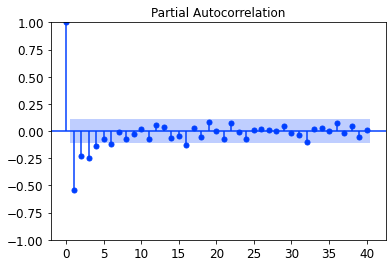

In [591]:
pacf_plot = plot_pacf(df['M01AB'].diff()[1:],lags=40)

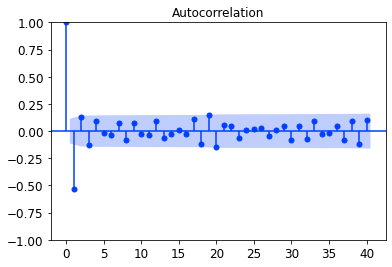

In [592]:
acf_plot = plot_acf(df['M01AB'].diff()[1:],lags=40)

### Grid search for the combination of (p.d,q) & (P,D,Q)m

In [568]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [427]:
sarima_grid_search(y,12)

The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:1962.1889989302063


##### The parameters found from the grid search does not give significant p-value. so parameters were chosen manually depending on the lowest value of AIC

In [607]:
order = (2,1,3)
seasonal_order = (2,1,3,12)
mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              M01AB   No. Observations:                  302
Model:             SARIMAX(2, 1, 3)x(2, 1, 3, 12)   Log Likelihood                -883.917
Date:                            Mon, 25 Jul 2022   AIC                           1789.833
Time:                                    09:25:18   BIC                           1828.525
Sample:                                01-05-2014   HQIC                          1805.407
                                     - 10-13-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5112      0.121    -12.463      0.000      -1.749      -1.274
ar.L2         -0.8270      0.110   

### Model fitting, forecasting & evaluation

In [569]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))
    
    
    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()
    
    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5112      0.121    -12.463      0.000      -1.749      -1.274
ar.L2         -0.8270      0.110     -7.529      0.000      -1.042      -0.612
ma.L1          0.5842      0.113      5.178      0.000       0.363       0.805
ma.L2         -0.4931      0.071     -6.938      0.000      -0.632      -0.354
ma.L3         -0.7892      0.088     -8.988      0.000      -0.961      -0.617
ar.S.L12      -0.3438      0.275     -1.252      0.211      -0.882       0.194
ar.S.L24      -0.5292      0.231     -2.289      0.022      -0.982      -0.076
ma.S.L12      -0.6188      5.050     -0.123      0.902     -10.517       9.280
ma.S.L24       0.1642      1.915      0.086      0.932      -3.589       3.917
ma.S.L36      -0.5470      2.742     -0.199      0.842      -5.922       4.828
sigma2        63.6186    319.097      0.199      0.8

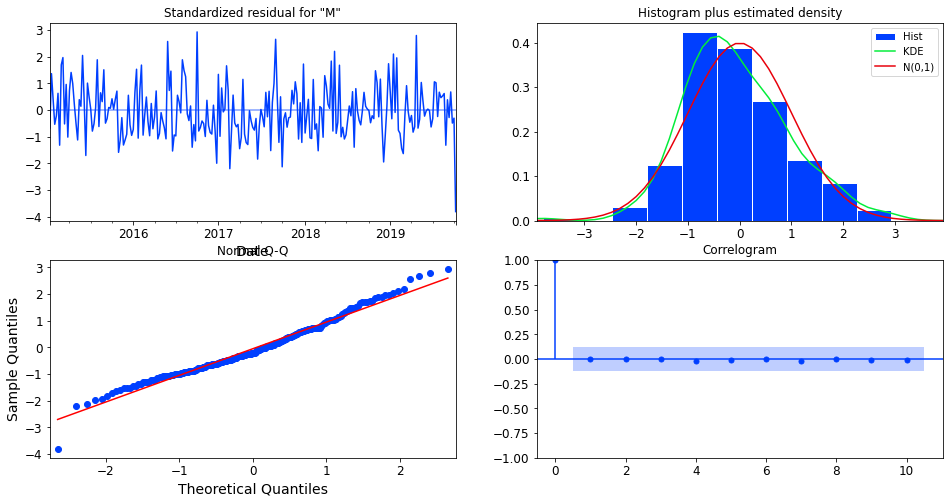

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 8.22


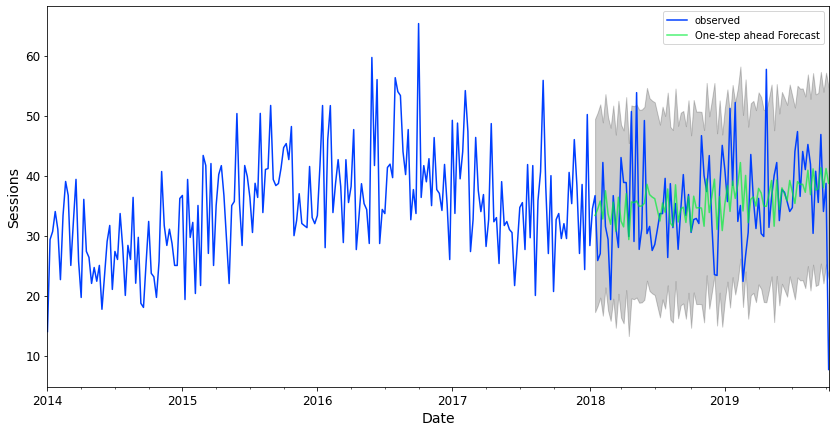

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = True 7.9


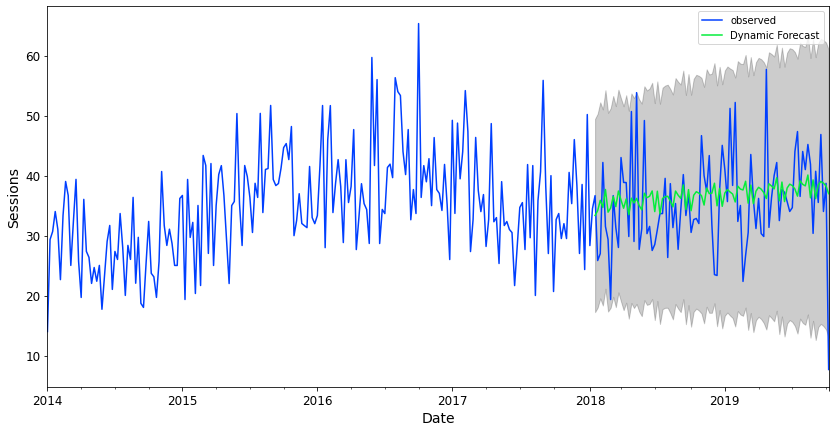

In [570]:
model = sarima_eva(y,(2, 1, 3),(2, 1, 3, 12),12,'2018-01-21',y_to_val)

### Making Predictions

In [571]:
def forecast(model,predict_steps,y): #predict_steps = 12 weeks(3 months)
    
    pred_uc = model.get_forecast(steps=predict_steps)

    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
    
    #print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.05)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

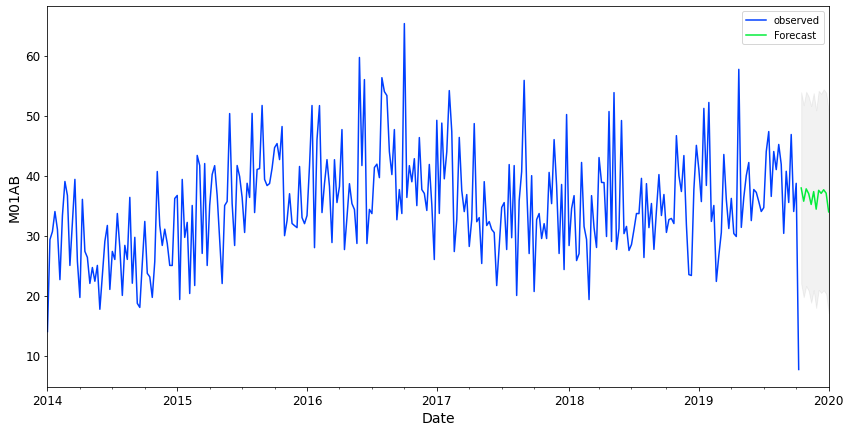

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2019-10-20,37.93,21.97,53.89
1,2019-10-27,35.72,19.72,51.73
2,2019-11-03,37.78,21.59,53.97
3,2019-11-10,36.98,20.79,53.17
4,2019-11-17,35.18,18.79,51.57


In [572]:
final_table = forecast(model,12,y)
final_table.head()

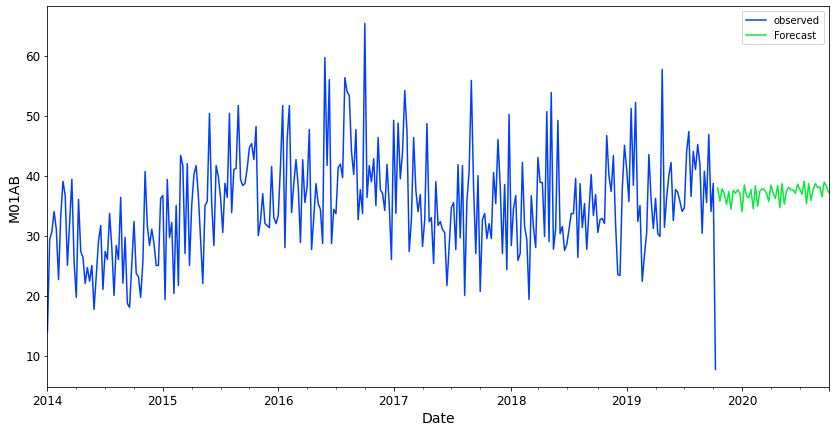

In [511]:
### Graphs without the confident interval 
pred_uc = model.get_forecast(steps=51)
ax = y.plot(label='observed', figsize=(14, 7))
#print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

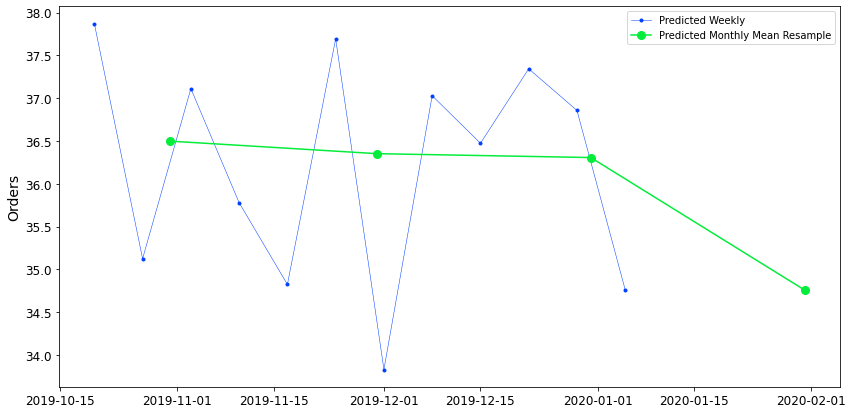

In [512]:
### Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14, 7))
# ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
# ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

# 2.Prophet model

In [609]:
import warnings; 
warnings.simplefilter('ignore')
import pandas as pd
import prophet
from prophet.plot import plot_plotly,plot_components_plotly
from prophet import Prophet
from statsmodels.tools.eval_measures import rmse

# Load & preprocess data

In [610]:
#load the dataset
df_daily = pd.read_csv("C:\\Users\\User\\Desktop\\Ryerson\\CIND 820\\Dataset\\salesdaily.csv")
df_daily.drop(['Year','Month','Hour','Weekday Name','M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03','R06'], axis=1, inplace=True)
df_daily['datum'] = pd.to_datetime(df_daily['datum'])
df_daily.rename(columns = {'datum':'Date'}, inplace = True)

df_daily.head()

,Date,M01AB
0,2014-01-02,0.00000000
1,2014-01-03,8.00000000
2,2014-01-04,2.00000000
3,2014-01-05,4.00000000
4,2014-01-06,5.00000000


In [611]:
df_daily.columns = ['ds', 'y']
df_daily.head()

,ds,y
0,2014-01-02,0.00000000
1,2014-01-03,8.00000000
2,2014-01-04,2.00000000
3,2014-01-05,4.00000000
4,2014-01-06,5.00000000


# Create the model

### a.Train,Test Split

In [612]:
train = df_daily.iloc[:len(df_daily)-631]
test = df_daily.iloc[len(df_daily)-631:]

### b.Fitting the model & making predictions

##### yearly seasonality is present so yearly_seasonality=True and from test to prediction there are 25 months so periods=25

In [613]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)
m.fit(train)
future = m.make_future_dataframe(periods=25,freq='M')
forecast = m.predict(future)
forecast.tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1495,2019-09-30,3.91749797,-1.29748927,9.01358813,3.37757268,4.50201301,0.07397151,0.07397151,0.07397151,-0.06632676,-0.06632676,-0.06632676,0.14029827,0.14029827,0.14029827,0.00000000,0.00000000,0.00000000,3.99146948
1496,2019-10-31,3.86901677,-2.29747049,7.81474129,3.29540081,4.49788465,-0.70136209,-0.70136209,-0.70136209,-0.39623424,-0.39623424,-0.39623424,-0.30512785,-0.30512785,-0.30512785,0.00000000,0.00000000,0.00000000,3.16765468
1497,2019-11-30,3.82209948,-1.15452731,9.25908658,3.22116415,4.49112569,0.13716404,0.13716404,0.13716404,0.59457000,0.59457000,0.59457000,-0.45740596,-0.45740596,-0.45740596,0.00000000,0.00000000,0.00000000,3.95926352
1498,2019-12-31,3.77361828,-0.95136150,9.11415413,3.13849471,4.48705330,0.11132828,0.11132828,0.11132828,0.10546718,0.10546718,0.10546718,0.00586110,0.00586110,0.00586110,0.00000000,0.00000000,0.00000000,3.88494657
1499,2020-01-31,3.72513709,-1.59317008,9.08775157,3.05294782,4.47054974,0.26596060,0.26596060,0.26596060,-0.21467588,-0.21467588,-0.21467588,0.48063648,0.48063648,0.48063648,0.00000000,0.00000000,0.00000000,3.99109769


In [614]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1495,2019-09-30,3.99146948,-1.29748927,9.01358813
1496,2019-10-31,3.16765468,-2.29747049,7.81474129
1497,2019-11-30,3.95926352,-1.15452731,9.25908658
1498,2019-12-31,3.88494657,-0.95136150,9.11415413
1499,2020-01-31,3.99109769,-1.59317008,9.08775157


### c.Visualizing the forecast 

In [615]:
plot_plotly(m,forecast)

##### in the plot,forecasted data did not fit that well to the actual data and some outliers are also present.

### d.Visualizing the trend

In [616]:
plot_components_plotly(m,forecast)

##### the trend is decreasing and yearly and weekly seasonality is clearly visible

# Evaluate the model

In [620]:
predictions = forecast.iloc[-631:]['yhat']
print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions,test['y']))

Root Mean Squared Error between actual and  predicted values:  2.895421862633083


# SVR model

In [621]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
import plotly.graph_objects as go 
import plotly.express as px


from sklearn.svm import SVR

from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

### Load the dataset

In [622]:
#load the dataset
df_daily = pd.read_csv("C:\\Users\\User\\Desktop\\Ryerson\\CIND 820\\Dataset\\salesdaily.csv")
df_daily.drop(['Year','Month','Hour','Weekday Name'], axis=1, inplace=True)

df_daily['datum'] = pd.to_datetime(df_daily['datum'])
df_daily.rename(columns = {'datum':'Date'}, inplace = True)
# Set the date as index 
df_daily = df_daily.set_index('Date')
df_daily.head()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
Date,,,,,,,,
2014-01-02,0.00,3.67,3.40,32.40,7.00,0.00,0.00,2.00
2014-01-03,8.00,4.00,4.40,50.60,16.00,0.00,20.00,4.00
2014-01-04,2.00,1.00,6.50,61.85,10.00,0.00,9.00,1.00
2014-01-05,4.00,3.00,7.00,41.10,8.00,0.00,3.00,0.00
2014-01-06,5.00,1.00,4.50,21.70,16.00,2.00,6.00,2.00


### Plotting the data

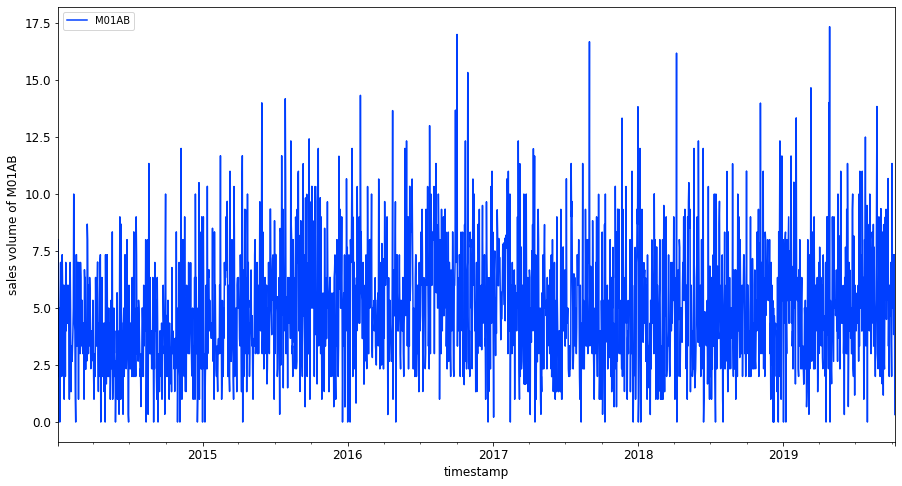

In [623]:
df_daily.plot(y='M01AB', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('sales volume of M01AB', fontsize=12)
plt.show()

### Create training and testing datasets

In [624]:
train_start_dt = '2014-01-02'
test_start_dt = '2018-01-16'

### Visualize the differences

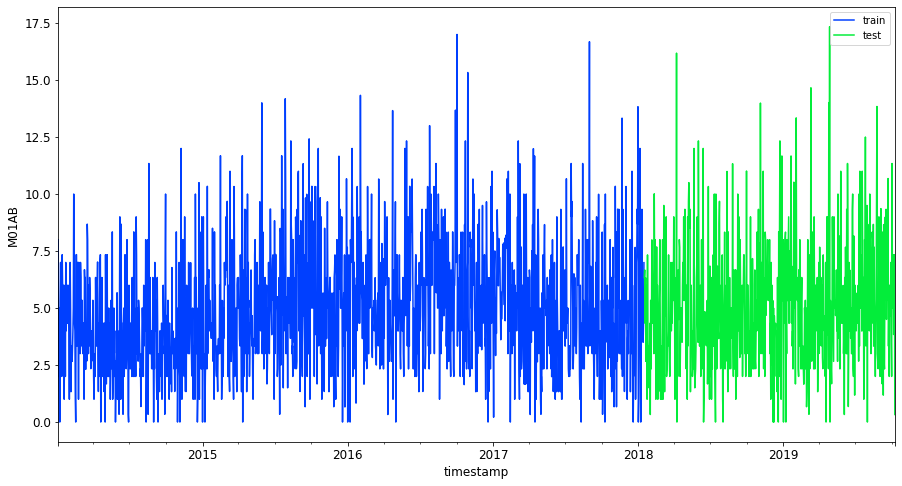

In [625]:
df_daily[(df_daily.index < test_start_dt) & (df_daily.index >= train_start_dt)][['M01AB']].rename(columns={'M01AB':'train'}) \
    .join(df_daily[test_start_dt:][['M01AB']].rename(columns={'M01AB':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('M01AB', fontsize=12)
plt.show()

### Prepare the data for training

In [626]:
train = df_daily.copy()[(df_daily.index >= train_start_dt) & (df_daily.index < test_start_dt)][['M01AB']]
test = df_daily.copy()[df_daily.index >= test_start_dt][['M01AB']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1475, 1)
Test data shape:  (631, 1)


In [627]:
# Scale the data to be in the range (0, 1)
scaler = MinMaxScaler()
train['M01AB'] = scaler.fit_transform(train)
train.head()

,M01AB
Date,
2014-01-02,0.00
2014-01-03,0.47
2014-01-04,0.12
2014-01-05,0.24
2014-01-06,0.29


In [628]:
test['M01AB'] = scaler.fit_transform(test)
test.head(5)

,M01AB
Date,
2018-01-16,0.37
2018-01-17,0.38
2018-01-18,0.25
2018-01-19,0.37
2018-01-20,0.15


### Create data with time-steps

In [629]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values
timesteps=5

In [630]:
#Converting training data to 2D tensor 
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(1471, 5)

In [631]:
#Converting testing data to 2D tensor
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(627, 5)

In [632]:
#Selecting inputs and outputs from training and testing data
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1471, 4) (1471, 1)
(627, 4) (627, 1)


### Hyperparameter tunning

In [633]:
model = SVR()

In [634]:
param_grid = {'kernel':['rbf'],'gamma': [0.1,0.01,0.001] , 'C':[0.1,1,10] ,'epsilon':[0.05,0.1]}

In [635]:
grid = GridSearchCV(SVR(),param_grid,refit = True, verbose = 3)

In [636]:
grid.fit(x_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf;, score=-0.230 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf;, score=-0.009 total time=   0.0s
[CV 3/5] END C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf;, score=-0.080 total time=   0.0s
[CV 4/5] END C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf;, score=-0.190 total time=   0.0s
[CV 5/5] END C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf;, score=-0.034 total time=   0.0s
[CV 1/5] END C=0.1, epsilon=0.05, gamma=0.01, kernel=rbf;, score=-0.280 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.05, gamma=0.01, kernel=rbf;, score=0.000 total time=   0.0s
[CV 3/5] END C=0.1, epsilon=0.05, gamma=0.01, kernel=rbf;, score=-0.104 total time=   0.0s
[CV 4/5] END C=0.1, epsilon=0.05, gamma=0.01, kernel=rbf;, score=-0.232 total time=   0.0s
[CV 5/5] END C=0.1, epsilon=0.05, gamma=0.01, kernel=rbf;, score=-0.006 total time=   0.0s
[CV 1/5] END C=0.1, epsilon=0.05, g

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'epsilon': [0.05, 0.1],
                         'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [637]:
grid.best_params_

{'C': 1, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

### Fit the model on training data

In [638]:
model = SVR(kernel='rbf',gamma=0.01, C=1, epsilon = 0.1)
model.fit(x_train, y_train[:,0])

SVR(C=1, gamma=0.01)

### Making predictions 

In [639]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(1471, 1) (627, 1)


 ### Evaluate the model

In [640]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

1471 627


In [641]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

1471 627


In [642]:
#Check model performance on training and testing data
train_timestamps = df_daily[(df_daily.index < test_start_dt) & (df_daily.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df_daily[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

1471 627


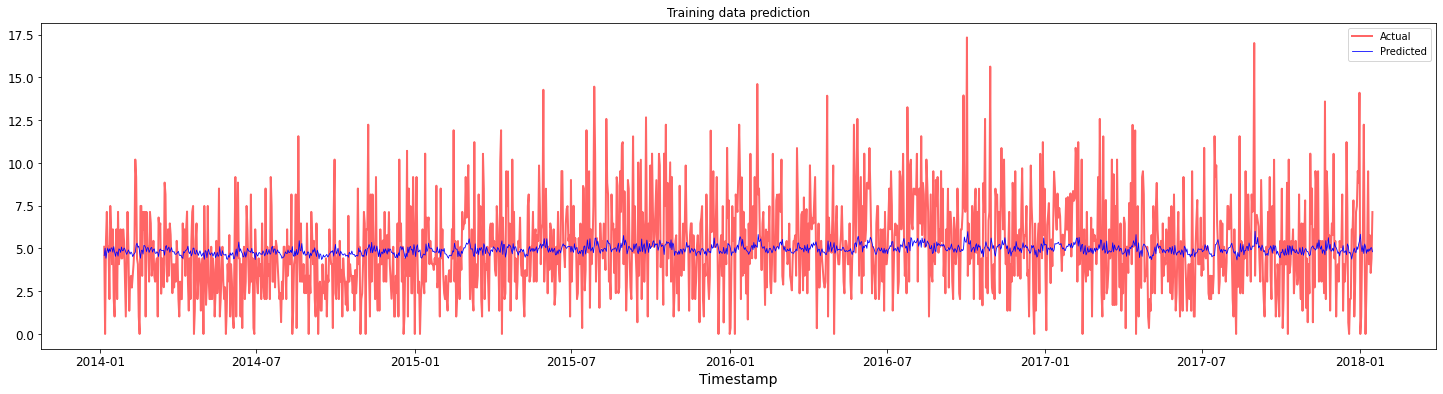

In [643]:
# Plot the predictions for training data
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [644]:
#Print RMSE for training data
rmse = np.sqrt(mse)
print(f'Root mean squared error: {rmse:.2f}')

Root mean squared error: 11.28


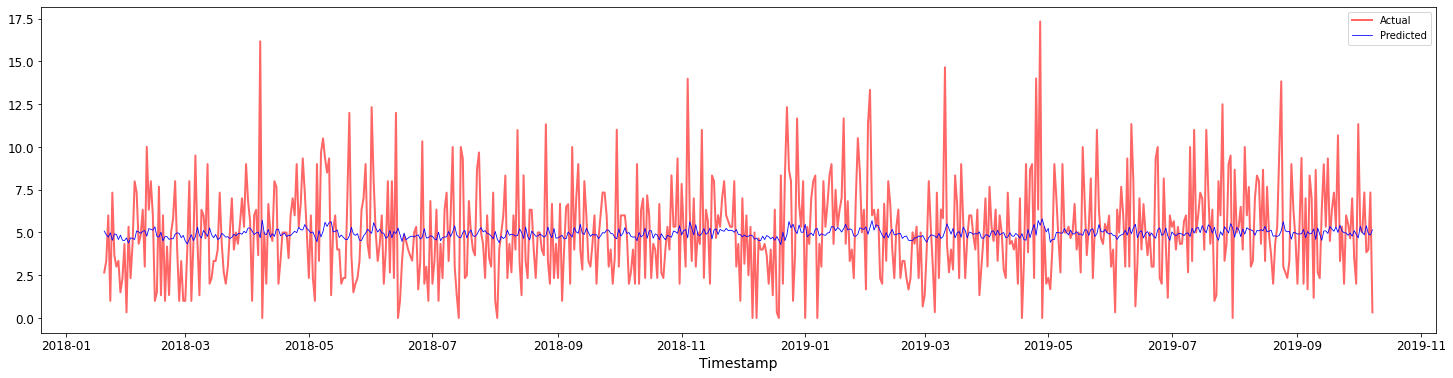

In [645]:
#plot the predictions for testing data
plt.figure(figsize=(25,6))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [646]:
#Print RMSE for testing data

rmse = np.sqrt(mse)
print(f'Root mean squared error: {rmse:.2f}')

Root mean squared error: 11.28


In [647]:
##Check model performance on full dataset 

# Extracting M01AB sales values as numpy array
data = df_daily.copy().values
data = data.reshape(-1, 1)

# Scaling
data = scaler.transform(data)

# Transforming to 2D tensor as per model input requirement
data_timesteps=np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps.shape)

# Selecting inputs and outputs from data
X, Y = data_timesteps[:,:timesteps-1],data_timesteps[:,[timesteps-1]]
print("X shape: ", X.shape,"\nY shape: ", Y.shape)

Tensor shape:  (16844, 5)
X shape:  (16844, 4) 
Y shape:  (16844, 1)


In [648]:
# Make model predictions
Y_pred = model.predict(X).reshape(-1,1)

# Inverse scale and reshape
Y_pred = scaler.inverse_transform(Y_pred)
Y = scaler.inverse_transform(Y)

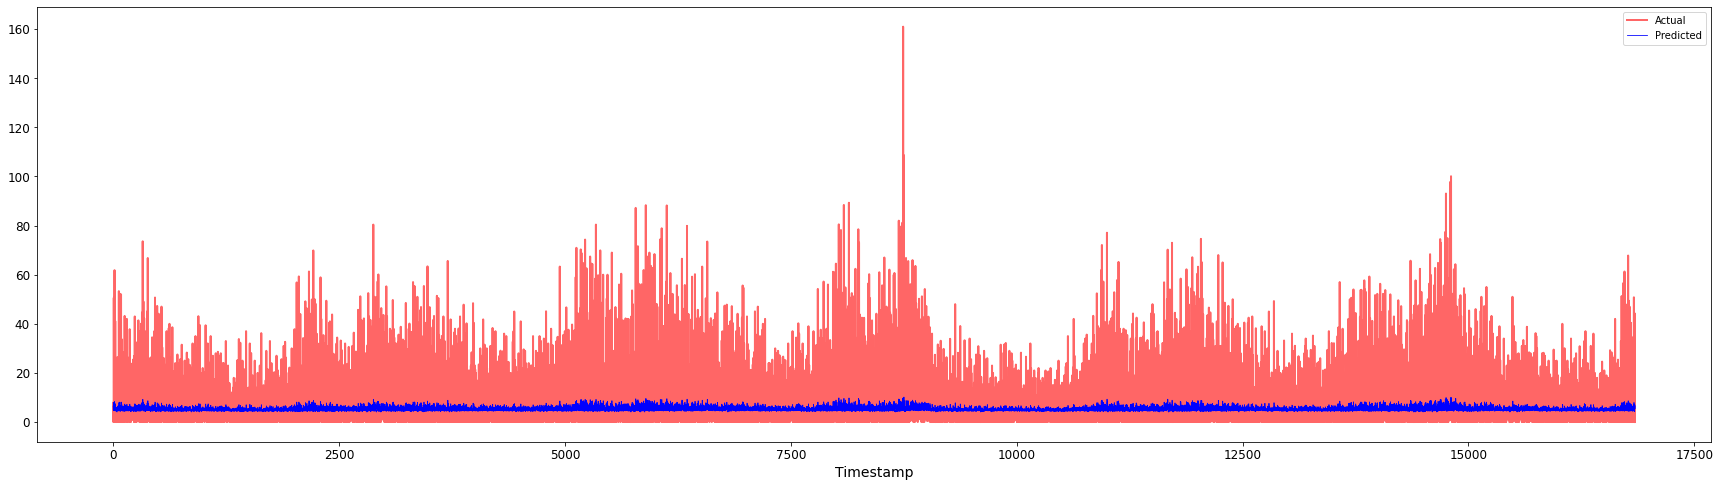

In [649]:
plt.figure(figsize=(30,8))
plt.plot(Y, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(Y_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [650]:
##Print RMSE for full dataset
rmse = np.sqrt(mse)
print(f'Root mean squared error: {rmse:.2f}')

Root mean squared error: 11.28
